In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

import numpy as np

import pandas as pd

import sys
import spacy
from sklearn.metrics import accuracy_score

import torch.optim as optim
from torch import nn
import torch

from torchtext import data
from torchtext.vocab import Vectors
from torch.nn import functional as F

import nltk
nltk.download('punkt')
nltk.download('wordnet')
import re
import string 

train_test_file = '/content/drive/My Drive/studies/nlp/finalProject/gender-classifier-DFE-791531.csv'
w2v_file = '/content/drive/My Drive/test_data/glove.840B.300d.txt'
data_encoding = "latin1"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Data Visualization**

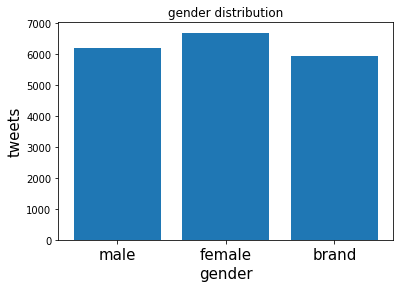

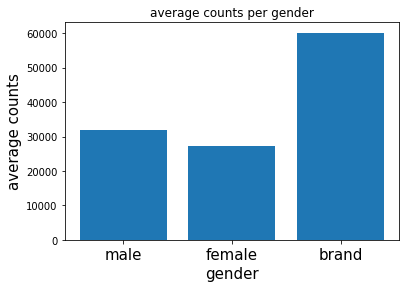

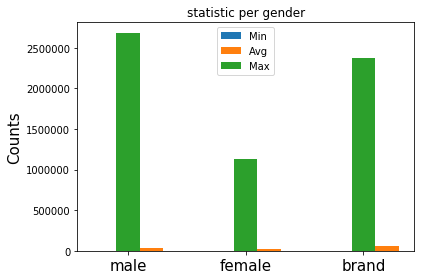

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

# data statictics

data_csv = pd.read_csv(train_test_file , encoding = data_encoding)

# keep only gender and tweet text
data_csv = pd.concat( [ data_csv.gender, data_csv.description, data_csv.text, data_csv.tweet_count ], axis = 1 )

# remove unknown gender from data
data_csv = data_csv[data_csv.gender != "unknown"]


fontsize = 15


label = ['male', 'female', 'brand']
counts = [data_csv.gender.value_counts()[b] for b in label]
index = np.arange(len(label))
plt.bar(index, counts)
plt.xlabel('gender', fontsize=fontsize)
plt.ylabel('tweets', fontsize=fontsize)
plt.xticks(index, label, fontsize=fontsize)
plt.title('gender distribution')
plt.show()

lenlabel = np.arange(len(label))
malecount = data_csv.tweet_count[data_csv.gender == 'male']
femalecount = data_csv.tweet_count[data_csv.gender == 'female']
brandcount = data_csv.tweet_count[data_csv.gender == 'brand']
heights = [ malecount.mean(), femalecount.mean(), brandcount.mean() ]
plt.bar(lenlabel, heights )
plt.xlabel('gender', fontsize=fontsize)
plt.ylabel('average counts', fontsize=fontsize)
plt.xticks(lenlabel, label, fontsize=fontsize)
plt.title("average counts per gender")
plt.show()

mins = [ malecount.min(), femalecount.min(), brandcount.min() ]
means = [ malecount.mean(), femalecount.mean(), brandcount.mean() ]
maxs = [ malecount.max(), femalecount.max(), brandcount.max() ]
x = np.arange(len(label))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, mins, width, label='Min')
rects2 = ax.bar(x + width, means, width, label='Avg')
rects3 = ax.bar(x, maxs, width, label='Max')
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('statistic per gender')
ax.set_xticks(x)
ax.set_xticklabels(label, fontsize=fontsize)
ax.legend()
fig.tight_layout()
plt.show()



stopword length: 180


In [ ]:
# had probloms downloading nltk stopwords, so we downloaded them from http://www.nltk.org/nltk_data/ to a file
stopwords_file = "/content/drive/My Drive/studies/nlp/finalProject/nltk_stopwords_english"
with open(stopwords_file, 'r') as sw:
  l = sw.read()
  stop_words = l.split('\n')

print("stopword length: " + str(len(stop_words))) 

#loading the data
df = pd.read_csv(train_test_file , encoding = data_encoding)
headers = list(df.columns.values)

targets = {'female', 'male', 'brand'}

#Remove rows without classify or empty
filtered_df = df.loc[df['gender'].isin(['female', 'male', 'brand'])]

target = filtered_df["gender"]
filtered_df.loc[df['text'].isnull(),'text'] = "."
filtered_df.loc[df['description'].isnull(),'description'] = "."

tweets = filtered_df["text"].map(str) + " "+ filtered_df["description"]

df["gender"].value_counts()

import re
from nltk.corpus import stopwords
import string
import nltk

stop_words = list(stop_words) + list(string.punctuation) + list('__')
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
  
def tokenize(tweet, lowercase=False):
    tokens_without_SW = []
    tweet = re.sub(r'[^\x00-\x7f]*',r'',tweet) 
    tokens = tokens_re.findall(tweet)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
        
    for token in tokens:
        if token not in stop_words:
            tokens_without_SW.append(token)
    return tokens_without_SW


from collections import Counter


#Create 3 arrays, 1 for every target
female = df.loc[df['gender']== 'female']['text']
male = df.loc[df['gender']== 'male']['text']
brand = df.loc[df['gender']== 'brand']['text']

def getMostCommonWords(tweets_array):
    res = []
    c = Counter()
    for tweet in tweets_array:
        for token in tokenize(tweet, True):
            res.append(token)
    c.update(res)
    return c.most_common(10)

print("Top 10 words in Female target:\n")
print(getMostCommonWords(female))
print("\nTop 10 words in Male target:\n")
print(getMostCommonWords(male))
print("\nTop 10 words in Brand target:\n")
print(getMostCommonWords(brand))

stopword length: 180


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Top 10 words in Female target:

[('like', 451), ('get', 353), ('__', 333), ('one', 332), ('love', 315), ('day', 296), ('go', 278), ('people', 249), ('time', 241), ('know', 210)]

Top 10 words in Male target:

[('like', 352), ('get', 346), ('one', 267), ('time', 232), ('new', 216), ('love', 210), ('go', 205), ('people', 197), ('good', 186), ('day', 186)]

Top 10 words in Brand target:

[('weather', 2279), ('get', 1326), ('channel', 1169), ('15', 1166), ('updates', 1147), ('40', 727), ('39', 424), ('new', 244), ('amp', 191), ('us', 167)]


# **running the models**

In [ ]:
from enum import Enum

class DatasetEnum(Enum):
        GenderText = 1
        GenderTextDescription = 2
        GenderTextDescriptionTweetCount = 3
        GenderTextTweetCount = 4
        
def get_datafields(dataset_type, tokenizer):
        TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True)
        LABEL = data.Field(sequential=False, use_vocab=False)
        DESCRIPTION = data.Field(sequential=True, tokenize=tokenizer, lower=True)
        TWEET_COUNT = data.Field(sequential=False, use_vocab=False)
        
        if dataset_type == DatasetEnum.GenderText:     
            datafields = [("label",LABEL), ("text",TEXT)]          
        elif dataset_type == DatasetEnum.GenderTextDescription:     
            datafields = [("label",LABEL), ("description", DESCRIPTION), ("text",TEXT)]
        elif dataset_type == DatasetEnum.GenderTextDescriptionTweetCount:     
            datafields = [("label",LABEL), ("description", DESCRIPTION), ("text",TEXT), ("tweet_count", TWEET_COUNT)]
        elif dataset_type == DatasetEnum.GenderTextTweetCount:     
            datafields = [("label",LABEL), ("text",TEXT), ("tweet_count", TWEET_COUNT)]
            
        return datafields, TEXT, LABEL, DESCRIPTION, TWEET_COUNT                 
        

### Configurations
We used two types of configurations for data processing:
1. **text_process_args_vars**:
   determains the type of processing we are doing on the text fields -   
   i. keep_letters_only - removes all chars that are not english letters  
   ii. lemmatize  
   iii. remove_stopwords  
   iv. to_lower_case (we ended up running to_lower_case = True everytime)
   
2. **dataset_configs**:
   This configuration refers to what fields to keep from the dataset.  
   Gender and Text (tweet) are always used.  
   Description and Tweet Count are not always used.
   

**DEBUG flag** - 
this flag refers to debug logs

In [ ]:
text_process_args_vars = [
    {"keep_letters_only": True, "to_lower_case": True, "lemmatize": True, "remove_stopwords": True},
    {"keep_letters_only": True, "to_lower_case": True, "lemmatize": True, "remove_stopwords": False},
    {"keep_letters_only": True, "to_lower_case": True, "lemmatize": False, "remove_stopwords": True}, 
    {"keep_letters_only": True, "to_lower_case": True, "lemmatize": False, "remove_stopwords": False},
    {"keep_letters_only": False, "to_lower_case": True, "lemmatize": True, "remove_stopwords": True},
    {"keep_letters_only": False, "to_lower_case": True, "lemmatize": True, "remove_stopwords": False},
    {"keep_letters_only": False, "to_lower_case": True, "lemmatize": False, "remove_stopwords": True},
    {"keep_letters_only": False, "to_lower_case": True, "lemmatize": False, "remove_stopwords": False}]

dataset_configs = [
    {"dataset_type" : DatasetEnum.GenderText, "remove_brand" : True },
    {"dataset_type" : DatasetEnum.GenderText, "remove_brand" : False },
    {"dataset_type" : DatasetEnum.GenderTextDescription, "remove_brand" : True },
    {"dataset_type" : DatasetEnum.GenderTextDescription, "remove_brand" : False },
    {"dataset_type" : DatasetEnum.GenderTextTweetCount, "remove_brand" : True },
    {"dataset_type" : DatasetEnum.GenderTextTweetCount, "remove_brand" : False },
    {"dataset_type" : DatasetEnum.GenderTextDescriptionTweetCount, "remove_brand" : True },
    {"dataset_type" : DatasetEnum.GenderTextDescriptionTweetCount, "remove_brand" : False }
]

DEBUG = False

In [ ]:
# had probloms downloading nltk stopwords, so we downloaded them from http://www.nltk.org/nltk_data/ to a file
stopwords_file = "/content/drive/My Drive/studies/nlp/finalProject/nltk_stopwords_english"
with open(stopwords_file, 'r') as sw:
  l = sw.read()
  stop_words = l.split('\n')

print("stopword length: " + str(len(stop_words)))  


stopword length: 180


In [ ]:
# UTILS
def gender_int_value(gender):
    if gender == "female":
        return "1"
    elif gender == "male":
        return "2"
    elif gender == "brand":
        return "3"
    else:
        return "4"

def process_tweet(text, keep_letters_only=False, to_lower_case=False, lemmatize=False, remove_stopwords=False):
      if text == "" or not text:        
        text = "empty"
      lemma = nltk.WordNetLemmatizer()

      if keep_letters_only:       
        text = re.sub( "[^a-zA-z]", " ", text)
      if to_lower_case:       
        text = text.lower()


      text = nltk.word_tokenize(text)

      if lemmatize:        
        text = [ lemma.lemmatize(word) for word in text ]
      if remove_stopwords:        
        # had probloms downloading nltk stopwords, so we downloaded them from http://www.nltk.org/nltk_data/ to a file
        stopwords_file = "/content/drive/My Drive/studies/nlp/finalProject/nltk_stopwords_english"

        with open(stopwords_file, 'r') as sw:
          l = sw.read()
          stopwords = l.split('\n')
        
        # adding punctuation to the stopwords list
        stopwords = list(stop_words) + list(string.punctuation)
        text = [word for word in text if word not in stopwords]

      text = " ".join(text)
      return text


def evaluate_model(model, iterator):
    all_preds = []
    all_y = []
    for idx,batch in enumerate(iterator):
        if torch.cuda.is_available():
            x = batch.text.cuda()
        else:
            x = batch.text
        y_pred = model(x)
        predicted = torch.max(y_pred.cpu().data, 1)[1] + 1
        all_preds.extend(predicted.numpy())
        all_y.extend(batch.label.numpy())
    score = accuracy_score(all_y, np.array(all_preds).flatten())
    return score
        

In [ ]:
def get_train_test_df(filename, dataset_type, text_process_args, remove_brand=False):
    data_csv = pd.read_csv(filename, encoding="latin")
    
    # remove all rows that have "unknown" gender
    data_csv = data_csv[data_csv.gender != "unknown"]
    
    if remove_brand:
          data_csv = data_csv[data_csv.gender != "brand"]
    
    data_csv.gender = [ gender_int_value(currentGender) for currentGender in data_csv.gender ]

    
    
    data_csv.text = [ process_tweet(currentText, **text_process_args) for currentText in data_csv.text ]
    
    data_csv.description = [ process_tweet(str(currentDesc), **text_process_args) for currentDesc in data_csv.description ]
      
    data_csv.dropna( subset=["gender", "text", "description", "tweet_count"], inplace = True )
    
    if dataset_type == DatasetEnum.GenderText:     
        data_csv = pd.concat( [ data_csv.gender, data_csv.text], axis = 1 )
        data_csv.columns = ['label', 'text']  
    elif dataset_type == DatasetEnum.GenderTextDescription:     
        data_csv = pd.concat( [ data_csv.gender, data_csv.description, data_csv.text], axis = 1 )
        data_csv.columns = ['label', 'description', 'text']  
    elif dataset_type == DatasetEnum.GenderTextDescriptionTweetCount:     
        data_csv = pd.concat( [ data_csv.gender, data_csv.description, data_csv.text, data_csv.tweet_count], axis = 1 )
        data_csv.columns = ['label', 'description', 'text', 'tweet_count']  
    elif dataset_type == DatasetEnum.GenderTextTweetCount:     
        data_csv = pd.concat( [ data_csv.gender, data_csv.text, data_csv.tweet_count], axis = 1 )
        data_csv.columns = ['label', 'text', 'tweet_count']  

    msk = np.random.rand(len(data_csv)) < 0.8

    train = data_csv[msk]
    test = data_csv[~msk]

    print("done loading data")
    return train, test

def get_train_test_val(train_test_file, datafields, dataset_type, text_process_args, remove_brand=False):
    train_df, test_df = get_train_test_df(train_test_file, dataset_type, text_process_args, remove_brand)        
  
    train_examples = [data.Example.fromlist(i, datafields) for i in train_df.values.tolist()]
    train_data = data.Dataset(train_examples, datafields)

    test_examples = [data.Example.fromlist(i, datafields) for i in test_df.values.tolist()]
    test_data = data.Dataset(test_examples, datafields)

    train_data, val_data = train_data.split(split_ratio=0.8)

    return train_data, test_data, val_data

In [ ]:


def train_and_eval(model, config, dataset):
  if torch.cuda.is_available():
      model.cuda()
  model.train()
  optimizer = optim.SGD(model.parameters(), lr=config.lr)
  NLLLoss = nn.NLLLoss()
  model.add_optimizer(optimizer)
  model.add_loss_op(NLLLoss)


  train_losses = []
  val_accuracies = []

  for i in range(config.max_epochs):
      if DEBUG:
        print ("Epoch: {}".format(i))
      train_loss,val_accuracy = model.run_epoch(dataset.train_iterator, dataset.val_iterator, i)
      train_losses.append(train_loss)
      val_accuracies.append(val_accuracy)

  train_acc = evaluate_model(model, dataset.train_iterator)
  val_acc = evaluate_model(model, dataset.val_iterator)
  test_acc = evaluate_model(model, dataset.test_iterator)

  print ('Final Training Accuracy: {:.4f}'.format(train_acc))
  print ('Final Validation Accuracy: {:.4f}'.format(val_acc))
  print ('Final Test Accuracy: {:.4f}'.format(test_acc))

## Fast Text Model

In [ ]:
####### FastText MODEL #####

class FastTextConfig(object):
    embed_size = 300
    hidden_size = 10
    output_size = 4
    max_epochs = 30
    lr = 0.5
    batch_size = 128
    
class FastTextDataset(object):
    def __init__(self, config):
        self.config = config
        self.train_iterator = None
        self.test_iterator = None
        self.val_iterator = None
        self.vocab = []
        self.word_embeddings = {}
    

    def load_data(self, w2v_file, train_test_file, dataset_config, text_process_args):
        description = False        
        
        NLP = spacy.load('en')
        tokenizer = lambda sent: [x.text for x in NLP.tokenizer(sent) if x.text != " "]
        
        datafields, TEXT, LABEL, DESCRIPTION, TWEET_COUNT = get_datafields(dataset_config["dataset_type"], tokenizer)    
        train_data, test_data, val_data = get_train_test_val(train_test_file, datafields, dataset_config["dataset_type"], text_process_args, remove_brand = dataset_config["remove_brand"])
        
        
        print("building vocab")
        TEXT.build_vocab(train_data, vectors=Vectors(w2v_file))
        
        if dataset_config["dataset_type"] == DatasetEnum.GenderTextDescription or dataset_config["dataset_type"] == DatasetEnum.GenderTextDescriptionTweetCount:
          DESCRIPTION.vocab = TEXT.vocab
        
        
        self.word_embeddings = TEXT.vocab.vectors        
        self.vocab = TEXT.vocab
        
        
        self.train_iterator = data.BucketIterator(
            (train_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=True)
        
        self.val_iterator, self.test_iterator = data.BucketIterator.splits(
            (val_data, test_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=False)
        
        print ("Loaded {} training examples".format(len(train_data)))
        print ("Loaded {} test examples".format(len(test_data)))
        print ("Loaded {} validation examples".format(len(val_data)))
        
class fastText(nn.Module):
    def __init__(self, config, vocab_size, word_embeddings):
        super(fastText, self).__init__()
        self.config = config
        
        # Embedding Layer
        self.embeddings = nn.Embedding(vocab_size, self.config.embed_size)
        self.embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
        
        # Hidden Layer
        self.fc1 = nn.Linear(self.config.embed_size, self.config.hidden_size)
        
        # Output Layer
        self.fc2 = nn.Linear(self.config.hidden_size, self.config.output_size)
        
        # Softmax non-linearity
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        embedded_sent = self.embeddings(x).permute(1,0,2)
        h = self.fc1(embedded_sent.mean(1))
        z = self.fc2(h)
        return self.softmax(z)
    
    def add_optimizer(self, optimizer):
        self.optimizer = optimizer
        
    def add_loss_op(self, loss_op):
        self.loss_op = loss_op
    
    def reduce_lr(self):
        print("Reducing LR")
        for g in self.optimizer.param_groups:
            g['lr'] = g['lr'] / 2
                
    def run_epoch(self, train_iterator, val_iterator, epoch):        
        train_losses = []
        val_accuracies = []
        losses = []
        
        # Reduce learning rate as number of epochs increase
        if (epoch == int(self.config.max_epochs/3)) or (epoch == int(2*self.config.max_epochs/3)):
            self.reduce_lr()
                 
        for i, batch in enumerate(train_iterator):

            self.optimizer.zero_grad()

            if torch.cuda.is_available():            
                x = batch.text.cuda()
                y = (batch.label - 1).type(torch.cuda.LongTensor)
            else:               
                x = batch.text
                y = (batch.label - 1).type(torch.LongTensor)

            y_pred = self.__call__(x)
            loss = self.loss_op(y_pred, y)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            
            self.optimizer.step()
    
            
            if i % 100 == 0:
                if DEBUG:
                  print("Iter: {}".format(i+1))
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                if DEBUG:
                  print("\tAverage training loss: {:.5f}".format(avg_train_loss))
                losses = []
                
                # Evalute Accuracy on validation set
                val_accuracy = evaluate_model(self, val_iterator)
                if DEBUG:
                  print("\tVal Accuracy: {:.4f}".format(val_accuracy))
                self.train()
                
        return train_losses, val_accuracies

### Running the Fast Text Model

In [ ]:
##### FastText ######
def run_fast_text(config, dataset_config, text_process_args):
  print("################")
  print(text_process_args)
  print("################")
  dataset = FastTextDataset(config)
  dataset.load_data(w2v_file, train_test_file, dataset_config, text_process_args)
  model = fastText(config, len(dataset.vocab), dataset.word_embeddings)
  train_and_eval(model, config, dataset)
  
fast_text_config = FastTextConfig()

In [ ]:

##### FastText TRAIN ######
dataset_config = {"dataset_type" : DatasetEnum.GenderText, "remove_brand" : True }

print("#### Gender and Text , REMOVE Brand")

for text_process_args in text_process_args_vars: 
  run_fast_text(fast_text_config, dataset_config, text_process_args)


#### Gender and Text , REMOVE Brand
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 8378 training examples
Loaded 2518 test examples
Loaded 2095 validation examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reducing LR
Reducing LR
Final Training Accuracy: 0.5135
Final Validation Accuracy: 0.5126
Final Test Accuracy: 0.5254
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
building vocab
Loaded 8286 training examples
Loaded 2634 test examples
Loaded 2071 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5115
Final Validation Accuracy: 0.5109
Final Test Accuracy: 0.5330
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 8331 training examples
Loaded 2577 test examples
Loaded 2083 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5207
Final Validation Accuracy: 0.4950
Final Test Accuracy: 0.5157
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loadi

In [ ]:
##### FastText TRAIN ######
print(" FAST TEXT ")
print("################# Gender and Text, KEEP brand ################") 
dataset_config = {"dataset_type" : DatasetEnum.GenderText, "remove_brand" : False }

for text_process_args in text_process_args_vars: 
  run_fast_text(fast_text_config, dataset_config, text_process_args)

############### FastText #############
################# Gender and Text, KEEP brand ################
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 12109 training examples
Loaded 3797 test examples
Loaded 3027 validation examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reducing LR
Reducing LR
Final Training Accuracy: 0.5178
Final Validation Accuracy: 0.4879
Final Test Accuracy: 0.4938
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
building vocab
Loaded 12081 training examples
Loaded 3832 test examples
Loaded 3020 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5218
Final Validation Accuracy: 0.5040
Final Test Accuracy: 0.5057
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 12171 training examples
Loaded 3719 test examples
Loaded 3043 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5245
Final Validation Accuracy: 0.5021
Final Test Accuracy: 0.4816
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loa

In [ ]:
##### FastText TRAIN ######
print("###################### FastText #####################")
print("##############Gender Text and Description, REMOVE brand #############")
dataset_config = {"dataset_type" : DatasetEnum.GenderTextDescription, "remove_brand" : True }

for text_process_args in text_process_args_vars: 
  run_fast_text(fast_text_config, dataset_config, text_process_args)

###################### FastText #####################
##############Gender Text and Description, REMOVE brand #############
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 8299 training examples
Loaded 2617 test examples
Loaded 2075 validation examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reducing LR
Reducing LR
Final Training Accuracy: 0.5192
Final Validation Accuracy: 0.5075
Final Test Accuracy: 0.5094
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 8343 training examples
Loaded 2562 test examples
Loaded 2086 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5162
Final Validation Accuracy: 0.5235
Final Test Accuracy: 0.5078


In [ ]:
##### FastText TRAIN ######
print("###################### FastText #####################")
print("##############Gender Text and Description, REMOVE brand #############")
dataset_config = {"dataset_type" : DatasetEnum.GenderTextDescription, "remove_brand" : True }

for text_process_args in text_process_args_vars: 
  run_fast_text(fast_text_config, dataset_config, text_process_args)

###################### FastText #####################
##############Gender Text and Description, REMOVE brand #############
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 8262 training examples
Loaded 2664 test examples
Loaded 2065 validation examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reducing LR
Reducing LR
Final Training Accuracy: 0.6270
Final Validation Accuracy: 0.5826
Final Test Accuracy: 0.5901
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
building vocab
Loaded 8341 training examples
Loaded 2565 test examples
Loaded 2085 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5138
Final Validation Accuracy: 0.5372
Final Test Accuracy: 0.5045
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 8286 training examples
Loaded 2633 test examples
Loaded 2072 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5138
Final Validation Accuracy: 0.5130
Final Test Accuracy: 0.5234
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loadi

In [ ]:
##### FastText TRAIN ######
print("############ FastText ################")
print("################ Gender Text and Description, KEEP Brand ############")
dataset_config = {"dataset_type" : DatasetEnum.GenderTextDescription, "remove_brand" : False }

for text_process_args in text_process_args_vars: 
  run_fast_text(fast_text_config, dataset_config, text_process_args)

############ FastText ################
################ Gender Text and Description, KEEP Brand ############
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 12139 training examples
Loaded 3759 test examples
Loaded 3035 validation examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reducing LR
Reducing LR
Final Training Accuracy: 0.5185
Final Validation Accuracy: 0.5031
Final Test Accuracy: 0.4802
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
building vocab
Loaded 12093 training examples
Loaded 3817 test examples
Loaded 3023 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5255
Final Validation Accuracy: 0.4969
Final Test Accuracy: 0.4965
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 12106 training examples
Loaded 3800 test examples
Loaded 3027 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5145
Final Validation Accuracy: 0.5061
Final Test Accuracy: 0.4684
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loa

In [ ]:
##### FastText TRAIN ######
print("############ Fast Text ###############")
print("################# Gender Text Description and TweetCount, REMOVE Brand #######")
dataset_config = {"dataset_type" : DatasetEnum.GenderTextDescriptionTweetCount, "remove_brand" : True }

for text_process_args in text_process_args_vars: 
  run_fast_text(fast_text_config, dataset_config, text_process_args)


############ Fast Text ###############
################# Gender Text Description and TweetCount, REMOVE Brand #######
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 8318 training examples
Loaded 2593 test examples
Loaded 2080 validation examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reducing LR
Reducing LR
Final Training Accuracy: 0.5180
Final Validation Accuracy: 0.5082
Final Test Accuracy: 0.5145
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
building vocab
Loaded 8267 training examples
Loaded 2657 test examples
Loaded 2067 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5146
Final Validation Accuracy: 0.5206
Final Test Accuracy: 0.5156
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 8311 training examples
Loaded 2602 test examples
Loaded 2078 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5144
Final Validation Accuracy: 0.5438
Final Test Accuracy: 0.4981
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loadi

In [ ]:
print("################## Fast Text ####################")
print("############### Gender Text Desciption and Tweet Count, KEEP Brand ############")
dataset_config = {"dataset_type" : DatasetEnum.GenderTextDescriptionTweetCount, "remove_brand" : False }

for text_process_args in text_process_args_vars: 
  run_fast_text(fast_text_config, dataset_config, text_process_args)

################## Fast Text ####################
############### Gender Text Desciption and Tweet Count, KEEP Brand ############
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 12136 training examples
Loaded 3763 test examples
Loaded 3034 validation examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reducing LR
Reducing LR
Final Training Accuracy: 0.5171
Final Validation Accuracy: 0.5016
Final Test Accuracy: 0.4953
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
building vocab
Loaded 12116 training examples
Loaded 3788 test examples
Loaded 3029 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5203
Final Validation Accuracy: 0.5091
Final Test Accuracy: 0.4976
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 12094 training examples
Loaded 3815 test examples
Loaded 3024 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5179
Final Validation Accuracy: 0.5099
Final Test Accuracy: 0.4826
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loa

In [ ]:
print("############ Fast Text #############")
print("############# Gender Text and Tweet Count, REMOVE Brand #################")
dataset_config = {"dataset_type" : DatasetEnum.GenderTextTweetCount, "remove_brand" : True }

for text_process_args in text_process_args_vars: 
  run_fast_text(fast_text_config, dataset_config, text_process_args)

############ Fast Text #############
############# Gender Text and Tweet Count, REMOVE Brand #################
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 8310 training examples
Loaded 2604 test examples
Loaded 2077 validation examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reducing LR
Reducing LR
Final Training Accuracy: 0.5243
Final Validation Accuracy: 0.4949
Final Test Accuracy: 0.5031
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
building vocab
Loaded 8322 training examples
Loaded 2588 test examples
Loaded 2081 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5198
Final Validation Accuracy: 0.5108
Final Test Accuracy: 0.5062
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 8295 training examples
Loaded 2622 test examples
Loaded 2074 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5169
Final Validation Accuracy: 0.5174
Final Test Accuracy: 0.5099
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loadi

In [ ]:
print("############### Fast Text ##################")
print("############## Gender Text and Tweet Count, KEEP Brand ############")
dataset_config = {"dataset_type" : DatasetEnum.GenderTextTweetCount, "remove_brand" : False }

for text_process_args in text_process_args_vars: 
  run_fast_text(fast_text_config, dataset_config, text_process_args)

############### Fast Text ##################
############## Gender Text and Tweet Count, KEEP Brand ############
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 12118 training examples
Loaded 3785 test examples
Loaded 3030 validation examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reducing LR
Reducing LR
Final Training Accuracy: 0.5156
Final Validation Accuracy: 0.5172
Final Test Accuracy: 0.4787
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
building vocab
Loaded 12115 training examples
Loaded 3789 test examples
Loaded 3029 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5238
Final Validation Accuracy: 0.4982
Final Test Accuracy: 0.5044
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
building vocab
Loaded 12134 training examples
Loaded 3766 test examples
Loaded 3033 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5196
Final Validation Accuracy: 0.4985
Final Test Accuracy: 0.4750
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loa

## Seq2Seq Model

In [ ]:
class SeqToSeqConfig(object):
    embed_size = 300
    hidden_layers = 1
    hidden_size = 32
    bidirectional = True
    output_size = 4
    max_epochs = 15
    lr = 0.5
    batch_size = 128
    dropout_keep = 0.8
    max_sen_len = None # Sequence length for RNN

class SeqToSeqDataset(object):
    def __init__(self, config):
        self.config = config
        self.train_iterator = None
        self.test_iterator = None
        self.val_iterator = None
        self.vocab = []
        self.word_embeddings = {}
      
    def load_data(self, w2v_file, train_test_file, dataset_config, text_process_args):       
        NLP = spacy.load('en')
        tokenizer = lambda sent: [x.text for x in NLP.tokenizer(sent) if x.text != " "]
        
        datafields, TEXT, LABEL, DESCRIPTION, TWEET_COUNT = get_datafields(dataset_config["dataset_type"], tokenizer)            
        train_data, test_data, val_data = get_train_test_val(train_test_file, datafields, dataset_config["dataset_type"], text_process_args, remove_brand = dataset_config["remove_brand"])
                        
        TEXT.build_vocab(train_data, vectors=Vectors(w2v_file))
        
        if dataset_config["dataset_type"] == DatasetEnum.GenderTextDescription or dataset_config["dataset_type"] == DatasetEnum.GenderTextDescriptionTweetCount:
          DESCRIPTION.vocab = TEXT.vocab
          
        self.word_embeddings = TEXT.vocab.vectors
        self.vocab = TEXT.vocab
        
        self.train_iterator = data.BucketIterator(
            (train_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=True)
        
        self.val_iterator, self.test_iterator = data.BucketIterator.splits(
            (val_data, test_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=False)
        
        if DEBUG:
            print ("Loaded {} training examples".format(len(train_data)))
            print ("Loaded {} test examples".format(len(test_data)))
            print ("Loaded {} validation examples".format(len(val_data)))
        
        
class Seq2SeqAttention(nn.Module):
    def __init__(self, config, vocab_size, word_embeddings):
        super(Seq2SeqAttention, self).__init__()
        self.config = config
        
        # Embedding Layer
        self.embeddings = nn.Embedding(vocab_size, self.config.embed_size)
        self.embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
        
        # Encoder RNN
        self.lstm = nn.LSTM(input_size = self.config.embed_size,
                            hidden_size = self.config.hidden_size,
                            num_layers = self.config.hidden_layers,
                            bidirectional = self.config.bidirectional)
        
        # Dropout Layer
        self.dropout = nn.Dropout(self.config.dropout_keep)
        
        # Fully-Connected Layer
        self.fc = nn.Linear(
            self.config.hidden_size * (1+self.config.bidirectional) * 2,
            self.config.output_size
        )
        
        # Softmax non-linearity
        self.softmax = nn.Softmax()
                
    def apply_attention(self, rnn_output, final_hidden_state):
        '''
        Apply Attention on RNN output
        
        Input:
            rnn_output (batch_size, seq_len, num_directions * hidden_size): tensor representing hidden state for every word in the sentence
            final_hidden_state (batch_size, num_directions * hidden_size): final hidden state of the RNN
            
        Returns:
            attention_output(batch_size, num_directions * hidden_size): attention output vector for the batch
        '''
        hidden_state = final_hidden_state.unsqueeze(2)
        attention_scores = torch.bmm(rnn_output, hidden_state).squeeze(2)
        soft_attention_weights = F.softmax(attention_scores, 1).unsqueeze(2) #shape = (batch_size, seq_len, 1)
        attention_output = torch.bmm(rnn_output.permute(0,2,1), soft_attention_weights).squeeze(2)
        return attention_output
        
    def forward(self, x):
        # x.shape = (max_sen_len, batch_size)
        embedded_sent = self.embeddings(x)
        # embedded_sent.shape = (max_sen_len=20, batch_size=64,embed_size=300)

        ##################################### Encoder #######################################
        lstm_output, (h_n,c_n) = self.lstm(embedded_sent)
        # lstm_output.shape = (seq_len, batch_size, num_directions * hidden_size)
        
        # Final hidden state of last layer (num_directions, batch_size, hidden_size)
        batch_size = h_n.shape[1]
        h_n_final_layer = h_n.view(self.config.hidden_layers,
                                   self.config.bidirectional + 1,
                                   batch_size,
                                   self.config.hidden_size)[-1,:,:,:]
        
        ##################################### Attention #####################################
        # Convert input to (batch_size, num_directions * hidden_size) for attention
        final_hidden_state = torch.cat([h_n_final_layer[i,:,:] for i in range(h_n_final_layer.shape[0])], dim=1)
        
        attention_out = self.apply_attention(lstm_output.permute(1,0,2), final_hidden_state)
        # Attention_out.shape = (batch_size, num_directions * hidden_size)
        
        #################################### Linear #########################################
        concatenated_vector = torch.cat([final_hidden_state, attention_out], dim=1)
        final_feature_map = self.dropout(concatenated_vector) # shape=(batch_size, num_directions * hidden_size)
        final_out = self.fc(final_feature_map)
        return self.softmax(final_out)
    
    def add_optimizer(self, optimizer):
        self.optimizer = optimizer
        
    def add_loss_op(self, loss_op):
        self.loss_op = loss_op
    
    def reduce_lr(self):
        if DEBUG:
          print("Reducing LR")
        for g in self.optimizer.param_groups:
            g['lr'] = g['lr'] / 2
                
    def run_epoch(self, train_iterator, val_iterator, epoch):
        train_losses = []
        val_accuracies = []
        losses = []
        
        # Reduce learning rate as number of epochs increase
        if (epoch == int(self.config.max_epochs/3)) or (epoch == int(2*self.config.max_epochs/3)):
            self.reduce_lr()
            
        for i, batch in enumerate(train_iterator):
            self.optimizer.zero_grad()
            if torch.cuda.is_available():
                x = batch.text.cuda()
                y = (batch.label - 1).type(torch.cuda.LongTensor)
            else:
                x = batch.text
                y = (batch.label - 1).type(torch.LongTensor)
            y_pred = self.__call__(x)
            loss = self.loss_op(y_pred, y)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
    
            if i % 100 == 0:
                if DEBUG:
                  print("Iter: {}".format(i+1))
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                if DEBUG:
                  print("\tAverage training loss: {:.5f}".format(avg_train_loss))
                losses = []
                
                # Evalute Accuracy on validation set
                val_accuracy = evaluate_model(self, val_iterator)
                if DEBUG:
                  print("\tVal Accuracy: {:.4f}".format(val_accuracy))
                self.train()
                
        return train_losses, val_accuracies

### Running Seq2Seq

In [ ]:

##### Seq2Seq ######
def run_seq_to_seq(config, dataset_config, text_process_args):
  print("################")
  print(text_process_args)
  print("################")
  dataset = SeqToSeqDataset(config)
  dataset.load_data(w2v_file, train_test_file, dataset_config, text_process_args)
  model = Seq2SeqAttention(config, len(dataset.vocab), dataset.word_embeddings)
  train_and_eval(model, config, dataset)
  
seq_to_seq_config = SeqToSeqConfig()

In [ ]:
#### Seq2Seq TRAIN ######
print("##### Seq2Seq ####")
dataset_config = dataset_configs[0]
print(dataset_config)

for text_process_args in text_process_args_vars: 
  run_seq_to_seq(seq_to_seq_config, dataset_config, text_process_args)

##### Seq2Seq ####
{'dataset_type': <DatasetEnum.GenderText: 1>, 'remove_brand': True}
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
Loaded 8339 training examples
Loaded 2567 test examples
Loaded 2085 validation examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reducing LR
Reducing LR
Final Training Accuracy: 0.5107
Final Validation Accuracy: 0.5194
Final Test Accuracy: 0.5290
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
Loaded 8317 training examples
Loaded 2595 test examples
Loaded 2079 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5152
Final Validation Accuracy: 0.5075
Final Test Accuracy: 0.5241
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
Loaded 8382 training examples
Loaded 2514 test examples
Loaded 2095 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5156
Final Validation Accuracy: 0.5222
Final Test Accuracy: 0.5091
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loading data
Loaded 8281 training e

In [ ]:
import time
start = time.time()

dataset_config = dataset_configs[1]
print(dataset_config)

for text_process_args in text_process_args_vars: 
  run_seq_to_seq(seq_to_seq_config, dataset_config, text_process_args)
  
print("----- seconds from start:")
end = time.time()
print(end - start)

{'dataset_type': <DatasetEnum.GenderText: 1>, 'remove_brand': False}
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
Loaded 12153 training examples
Loaded 3742 test examples
Loaded 3038 validation examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:127: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reducing LR
Reducing LR
Final Training Accuracy: 0.5232
Final Validation Accuracy: 0.5016
Final Test Accuracy: 0.4832
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
Loaded 12170 training examples
Loaded 3720 test examples
Loaded 3043 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5264
Final Validation Accuracy: 0.4893
Final Test Accuracy: 0.4898
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
Loaded 12082 training examples
Loaded 3831 test examples
Loaded 3020 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5248
Final Validation Accuracy: 0.5076
Final Test Accuracy: 0.4931
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loading data
Loaded 12136 trainin

In [ ]:
import time
start = time.time()

dataset_config = dataset_configs[2]
print(dataset_config)

for text_process_args in text_process_args_vars: 
  run_seq_to_seq(seq_to_seq_config, dataset_config, text_process_args)
  
print("----- seconds from start:")
end = time.time()
print(end - start)

{'dataset_type': <DatasetEnum.GenderTextDescription: 2>, 'remove_brand': True}
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
Loaded 8338 training examples
Loaded 2568 test examples
Loaded 2085 validation examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:127: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reducing LR
Reducing LR
Final Training Accuracy: 0.5169
Final Validation Accuracy: 0.5026
Final Test Accuracy: 0.5226
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
Loaded 8354 training examples
Loaded 2549 test examples
Loaded 2088 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5177
Final Validation Accuracy: 0.5077
Final Test Accuracy: 0.5155
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
Loaded 8362 training examples
Loaded 2539 test examples
Loaded 2090 validation examples
Reducing LR
Reducing LR
Final Training Accuracy: 0.5175
Final Validation Accuracy: 0.5148
Final Test Accuracy: 0.5096
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loading data
Loaded 8270 training e

In [ ]:
import time
start = time.time()

dataset_config = dataset_configs[3]
print(dataset_config)

for text_process_args in text_process_args_vars: 
  run_seq_to_seq(seq_to_seq_config, dataset_config, text_process_args)
  
print("----- seconds from start:")
end = time.time()
print(end - start)

----- start time:
1569160291.9895594
{'dataset_type': <DatasetEnum.GenderTextDescription: 2>, 'remove_brand': False}
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Accuracy: 0.5223
Final Validation Accuracy: 0.4972
Final Test Accuracy: 0.4936
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
Final Training Accuracy: 0.3541
Final Validation Accuracy: 0.3588
Final Test Accuracy: 0.3520
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
Final Training Accuracy: 0.5209
Final Validation Accuracy: 0.5184
Final Test Accuracy: 0.4833
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loading data
Final Training Accuracy: 0.5217
Final Validation Accuracy: 0.5068
Final Test Accuracy: 0.5012
################
{'keep_letters_only': False, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
Final Training Accuracy: 0.

In [ ]:
import time
start = time.time()

dataset_config = dataset_configs[4]
print(dataset_config)

for text_process_args in text_process_args_vars: 
  run_seq_to_seq(seq_to_seq_config, dataset_config, text_process_args)
  
print("----- seconds from start:")
end = time.time()
print(end - start)

{'dataset_type': <DatasetEnum.GenderTextDescriptionTweetCount: 3>, 'remove_brand': True}
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Accuracy: 0.5168
Final Validation Accuracy: 0.5246
Final Test Accuracy: 0.5042
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
Final Training Accuracy: 0.5249
Final Validation Accuracy: 0.5413
Final Test Accuracy: 0.5234
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
Final Training Accuracy: 0.5127
Final Validation Accuracy: 0.5192
Final Test Accuracy: 0.5224
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loading data
Final Training Accuracy: 0.5214
Final Validation Accuracy: 0.5062
Final Test Accuracy: 0.5069
################
{'keep_letters_only': False, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
Final Training Accuracy: 0.

In [ ]:
import time
start = time.time()

dataset_config = dataset_configs[5]
print(dataset_config)

for text_process_args in text_process_args_vars: 
  run_seq_to_seq(seq_to_seq_config, dataset_config, text_process_args)
  
print("----- seconds from start:")
end = time.time()
print(end - start)

{'dataset_type': <DatasetEnum.GenderTextTweetCount: 4>, 'remove_brand': True}
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Accuracy: 0.5307
Final Validation Accuracy: 0.5460
Final Test Accuracy: 0.5474
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
Final Training Accuracy: 0.5160
Final Validation Accuracy: 0.5234
Final Test Accuracy: 0.5093
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
Final Training Accuracy: 0.5136
Final Validation Accuracy: 0.5131
Final Test Accuracy: 0.5316
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loading data
Final Training Accuracy: 0.5377
Final Validation Accuracy: 0.5493
Final Test Accuracy: 0.5307
################
{'keep_letters_only': False, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
Final Training Accuracy: 0.

In [ ]:
import time
start = time.time()

dataset_config = dataset_configs[6]
print(dataset_config)

for text_process_args in text_process_args_vars: 
  run_seq_to_seq(seq_to_seq_config, dataset_config, text_process_args)
  
print("----- seconds from start:")
end = time.time()
print(end - start)

{'dataset_type': <DatasetEnum.GenderTextTweetCount: 4>, 'remove_brand': False}
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Accuracy: 0.5124
Final Validation Accuracy: 0.5218
Final Test Accuracy: 0.4959
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
Final Training Accuracy: 0.5221
Final Validation Accuracy: 0.5241
Final Test Accuracy: 0.4984
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
Final Training Accuracy: 0.5254
Final Validation Accuracy: 0.5015
Final Test Accuracy: 0.4918
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loading data
Final Training Accuracy: 0.3534
Final Validation Accuracy: 0.3569
Final Test Accuracy: 0.3648
################
{'keep_letters_only': False, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
Final Training Accuracy: 0.

In [ ]:
import time
start = time.time()

dataset_config = dataset_configs[7]
print(dataset_config)

for text_process_args in text_process_args_vars: 
  run_seq_to_seq(seq_to_seq_config, dataset_config, text_process_args)
  
print("----- seconds from start:")
end = time.time()
print(end - start)

{'dataset_type': <DatasetEnum.GenderTextDescriptionTweetCount: 3>, 'remove_brand': False}
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Accuracy: 0.5255
Final Validation Accuracy: 0.5115
Final Test Accuracy: 0.4684
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
Final Training Accuracy: 0.5150
Final Validation Accuracy: 0.5126
Final Test Accuracy: 0.5127
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
Final Training Accuracy: 0.5249
Final Validation Accuracy: 0.5010
Final Test Accuracy: 0.4596
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loading data
Final Training Accuracy: 0.5130
Final Validation Accuracy: 0.5117
Final Test Accuracy: 0.4989
################
{'keep_letters_only': False, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
Final Training Accuracy: 0.

## Text RNN Model

In [ ]:
class TextRNNConfig(object):
    embed_size = 300
    hidden_layers = 2
    hidden_size = 32
    bidirectional = True
    output_size = 4
    max_epochs = 10
    lr = 0.25
    batch_size = 64
    max_sen_len = 20 # Sequence length for RNN
    dropout_keep = 0.8
    
class TextRNN(nn.Module):
    def __init__(self, config, vocab_size, word_embeddings):
        super(TextRNN, self).__init__()
        self.config = config
        
        # Embedding Layer
        self.embeddings = nn.Embedding(vocab_size, self.config.embed_size)
        self.embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
        
        self.lstm = nn.LSTM(input_size = self.config.embed_size,
                            hidden_size = self.config.hidden_size,
                            num_layers = self.config.hidden_layers,
                            dropout = self.config.dropout_keep,
                            bidirectional = self.config.bidirectional)
        
        self.dropout = nn.Dropout(self.config.dropout_keep)
        
        # Fully-Connected Layer
        self.fc = nn.Linear(
            self.config.hidden_size * self.config.hidden_layers * (1+self.config.bidirectional),
            self.config.output_size
        )
        
        # Softmax non-linearity
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        # x.shape = (max_sen_len, batch_size)
        embedded_sent = self.embeddings(x)
        # embedded_sent.shape = (max_sen_len=20, batch_size=64,embed_size=300)

        lstm_out, (h_n,c_n) = self.lstm(embedded_sent)
        final_feature_map = self.dropout(h_n) # shape=(num_layers * num_directions, 64, hidden_size)
        
        # Convert input to (64, hidden_size * hidden_layers * num_directions) for linear layer
        final_feature_map = torch.cat([final_feature_map[i,:,:] for i in range(final_feature_map.shape[0])], dim=1)
        final_out = self.fc(final_feature_map)
        return self.softmax(final_out)
    
    def add_optimizer(self, optimizer):
        self.optimizer = optimizer
        
    def add_loss_op(self, loss_op):
        self.loss_op = loss_op
    
    def reduce_lr(self):
        if DEBUG:
          print("Reducing LR")
        for g in self.optimizer.param_groups:
            g['lr'] = g['lr'] / 2
                
    def run_epoch(self, train_iterator, val_iterator, epoch):
        train_losses = []
        val_accuracies = []
        losses = []
        
        # Reduce learning rate as number of epochs increase
        if (epoch == int(self.config.max_epochs/3)) or (epoch == int(2*self.config.max_epochs/3)):
            self.reduce_lr()
            
        for i, batch in enumerate(train_iterator):
            self.optimizer.zero_grad()
            if torch.cuda.is_available():
                x = batch.text.cuda()
                y = (batch.label - 1).type(torch.cuda.LongTensor)
            else:
                x = batch.text
                y = (batch.label - 1).type(torch.LongTensor)
            y_pred = self.__call__(x)
            loss = self.loss_op(y_pred, y)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
    
            if i % 100 == 0:
                if DEBUG:
                  print("Iter: {}".format(i+1))
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                if DEBUG:
                  print("\tAverage training loss: {:.5f}".format(avg_train_loss))
                losses = []
                
                # Evalute Accuracy on validation set
                val_accuracy = evaluate_model(self, val_iterator)
                if DEBUG:
                  print("\tVal Accuracy: {:.4f}".format(val_accuracy))
                self.train()
                
        return train_losses, val_accuracies
      
class TextRNNDataset(object):
    def __init__(self, config):
        self.config = config
        self.train_iterator = None
        self.test_iterator = None
        self.val_iterator = None
        self.vocab = []
        self.word_embeddings = {}       
    
    def load_data(self, w2v_file, train_test_file, dataset_config, text_process_args):       

        NLP = spacy.load('en')
        tokenizer = lambda sent: [x.text for x in NLP.tokenizer(sent) if x.text != " "]
        
        datafields, TEXT, LABEL, DESCRIPTION, TWEET_COUNT = get_datafields(dataset_config["dataset_type"], tokenizer)            
        train_data, test_data, val_data = get_train_test_val(train_test_file, datafields, dataset_config["dataset_type"], text_process_args, remove_brand = dataset_config["remove_brand"])
        
        
        
        TEXT.build_vocab(train_data, vectors=Vectors(w2v_file))
        self.word_embeddings = TEXT.vocab.vectors
        self.vocab = TEXT.vocab
        
        if dataset_config["dataset_type"] == DatasetEnum.GenderTextDescription or dataset_config["dataset_type"] == DatasetEnum.GenderTextDescriptionTweetCount:
          DESCRIPTION.vocab = TEXT.vocab
          
        self.train_iterator = data.BucketIterator(
            (train_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=True)
        
        self.val_iterator, self.test_iterator = data.BucketIterator.splits(
            (val_data, test_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            shuffle=False)
        if DEBUG:
          print ("Loaded {} training examples".format(len(train_data)))
          print ("Loaded {} test examples".format(len(test_data)))
          print ("Loaded {} validation examples".format(len(val_data)))

### Running Text RNN

In [ ]:
##### TEXT RNN ######
def run_text_rnn(config, dataset_config, text_process_args):
  print("################")
  print(text_process_args)
  print("################")
  dataset = TextRNNDataset(config)
  dataset.load_data(w2v_file, train_test_file, dataset_config, text_process_args)
  model = TextRNN(config, len(dataset.vocab), dataset.word_embeddings)
  train_and_eval(model, config, dataset)
  
text_rnn_config = TextRNNConfig()


In [ ]:
import time
start = time.time()

for dataset_config in dataset_configs:
  print(dataset_config)

  for text_process_args in text_process_args_vars: 
    run_text_rnn(text_rnn_config, dataset_config, text_process_args)
  print("----- seconds from start:")
  end = time.time()
  print(end - start)

print("----- TOTAL seconds from start:")
end = time.time()
print(end - start)
  

{'dataset_type': <DatasetEnum.GenderText: 1>, 'remove_brand': True}
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data


100%|█████████▉| 2195899/2196018 [05:31<00:00, 7823.64it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Accuracy: 0.5228
Final Validation Accuracy: 0.4976
Final Test Accuracy: 0.5076
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': False}
################
done loading data
Final Training Accuracy: 0.5635
Final Validation Accuracy: 0.5607
Final Test Accuracy: 0.5565
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': True}
################
done loading data
Final Training Accuracy: 0.5201
Final Validation Accuracy: 0.4966
Final Test Accuracy: 0.5172
################
{'keep_letters_only': True, 'to_lower_case': True, 'lemmatize': False, 'remove_stopwords': False}
################
done loading data
Final Training Accuracy: 0.5151
Final Validation Accuracy: 0.5378
Final Test Accuracy: 0.5141
################
{'keep_letters_only': False, 'to_lower_case': True, 'lemmatize': True, 'remove_stopwords': True}
################
done loading data
Final Training Accuracy: 0.